# Calculo de MACD

## Método 1 - Cálculo indirecto


Obteniendo el MACD de Google consultando Alpha Vantage

In [58]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

 Definimos la función $\textbf{'get_historical_data'}$. La cual realiza la solicitud a la página Alpha Vantage por medio de su API, lee la información y la pone en un data frame manejable

In [59]:
def get_historical_data(symbol, start_date = None):
    api_key = '5GPURD4JJT7WKSJZ'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    #El url contiene el link de la página a requisitar con request y la información adicional como el api key leído en el txt
    raw_df = requests.get(api_url).json() #Hace el request a la api
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T #Crea el data frame con la información contenida en Time Series (Daily)
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    #Renombra las columnas para un uso más fácil
    
    for i in df.columns:
        df[i] = df[i].astype(float) #Convierte los archivos a flotante
        
    df.index = pd.to_datetime(df.index) #Convierte el tipo de los datos en index (tal vez array)a foromato de fecha
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1) #Suelta la información contenida en '7. dividend amount' y en '8. split coeficient'
    
    if start_date:
        df = df[df.index >= start_date] #wotefoc
    return df

Definimos una función llamada $\textbf{'get_macd'}$ que toma como parámetros la lista de precios 'price', el tamaño del periodo lento 'slow', el tamaño del periodo largo 'fast', y el periodo de la linea de señal 'smooth'

In [60]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean() #Crea un data frame con el cálculo de la Exponential Weighted Function cada periodo 'fast'
    exp2 = price.ewm(span = slow, adjust = False).mean() #Crea un data frame con el cálculo de la Exponential Weighted Function cada periodo 'slow'
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'}) # Crea el data frame macd con la información 
                    #obtenida a partir de restar la información contenida en los data frames 'exp1', 'exp2
    
    #Crea el data frame signal cuya información es el cálculo EWM utilizando el periodo proporcionado por 'smooth', a su vez renombra la columna 'macd' por 'signal
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'}) 
    
    #Crea el data frame 'hist' a partir de la resta de las entradas de los data frames 'macd' y 'signal', a su vez renombra la primer columna como 'hist'
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    
    #Crea una lista cuyas entradas son los dataframes 'macd', 'signals', 'hist'
    frames =  [macd, signal, hist] 
    #Crea un dataframe único a partir de los dataframes contenidos en la lista 'frames'
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df



Obtenemos los datos y calculamos el MACD llamando a las funciones definidas anteriormente

In [61]:
googl = get_historical_data('GOOGL', '2020-01-01') 
googl
googl_macd = get_macd(googl['close'], 26, 12, 9)
googl_macd.tail() #regresa las últimas 5 columnas si no se especifica el número de columnas en el parámetro (en este caso no hay más de 4)


,macd,signal,hist
2023-06-08,3.698771,4.267819,-0.569049
2023-06-09,3.360525,4.086360,-0.725836
2023-06-12,3.169699,3.903028,-0.733329
2023-06-13,2.999227,3.722268,-0.723041
2023-06-14,2.818723,3.541559,-0.722836


definimos una función que nos ayudará a graficar la información contenida en el dataframe creado

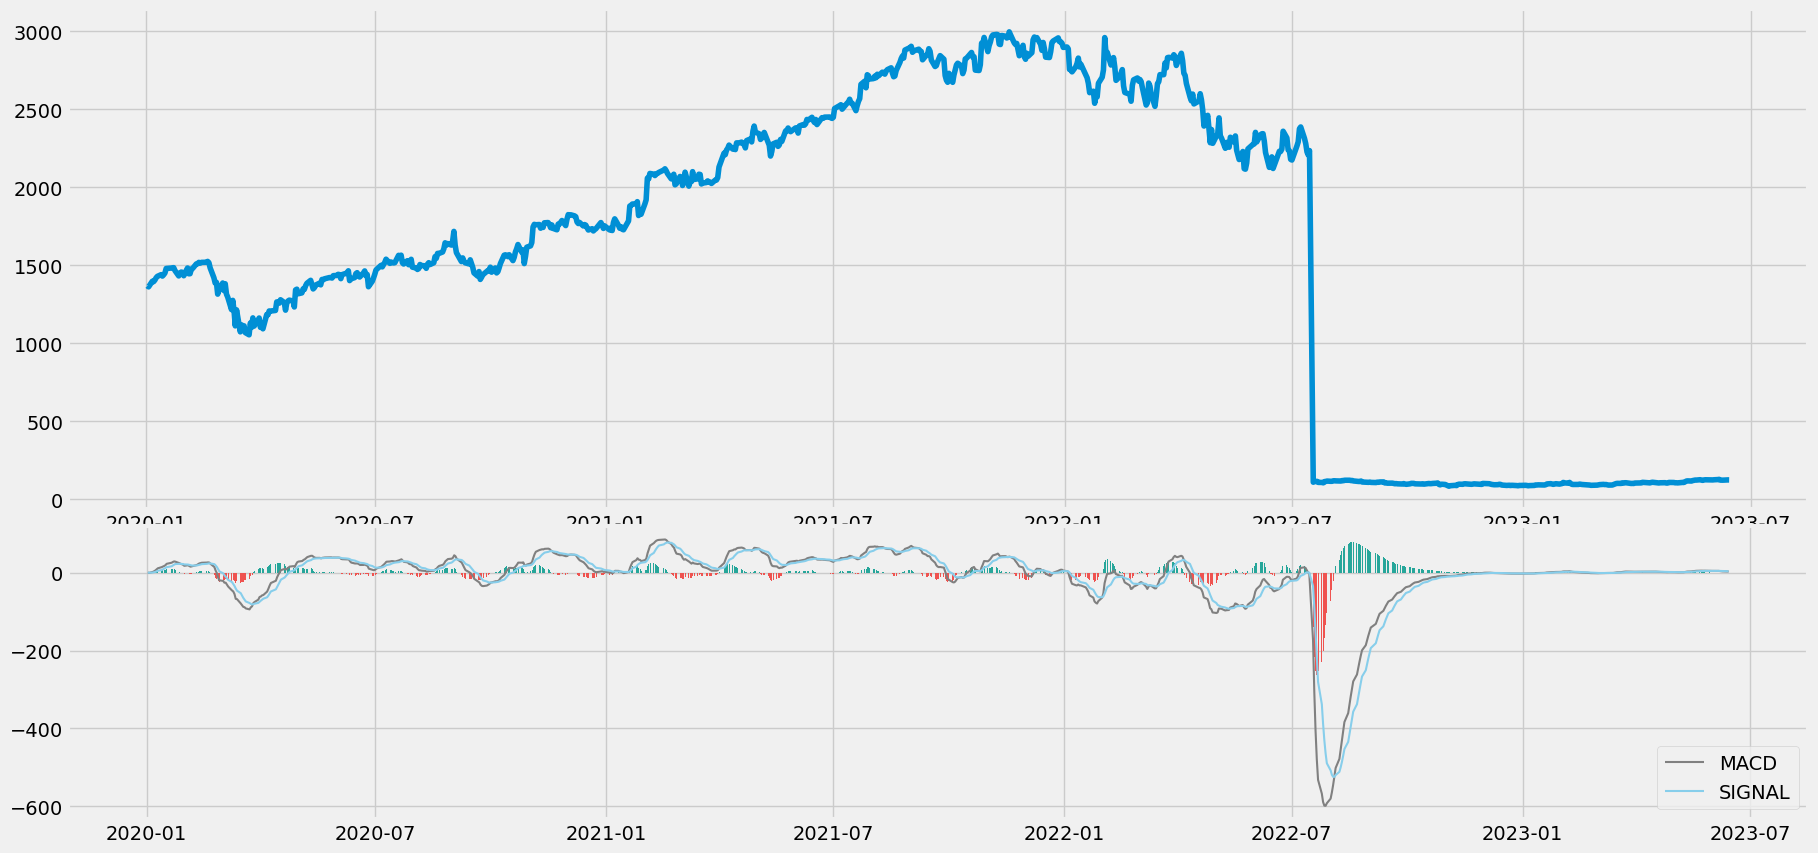

In [62]:
def plot_macd(prices, macd, signal, hist):
    
    #Se realizarán dos gráficas, una con el precio y otra con la información en 'macd', 'signal' y el histograma
    
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1) #define el eje x de la primer grafica
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1) #define el eje x de la segunda gráfica

    ax1.plot(prices) #grafica la información en el data frame 'prices'
    #grafica la información en el data frame 'MACD'
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD') 
    #grafica la información en el data frame 'SIGNAL'
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    
    
    for i in range(len(prices)):
        #Este if verifica si el número es negativo, en este caso convierte el número en un string y verifica si su primer entrada 
        #es el caracter '-' 
        if str(hist[i])[0] == '-': 
            # El .bar hace que se grafique como como una gráfica de barras, prices.index[i] arroja la i-ésima fecha
            ax2.bar(prices.index[i], hist[i], color = '#ef5350') #Los valores negativos los grafica en rojo
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a') #los valores positivos los grafica en verde
    
    #Añade la legenda con localización abajo a la derecha
    plt.legend(loc = 'lower right')

plot_macd(googl['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

## Método 2 - Calculo directo

Importamos las librerías necesarias, yfinance para solicitar información, pandas y numpy para manipular los dataframes obtenidos y 

In [63]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import plotly.subplots
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import yfinance as yf

Obtenemos la información con un request

Solicitamos los datos diarios en un periodo de un año del precio de cierre, de apertura, precio más alto, volumen de transacciones y precio más bajo

In [64]:
df = yf.Ticker('BTC-USD').history(period='1y')[['Close', 'Open', 'High', 'Volume', 'Low']]

Calculamos el MACD utilizando un EMA de 12 y 9 días respectivamente, la cual está dada por la fórmula,
$$ MACD = EMA_{26} - EMA_{12} $$
Con una señal (media móvil) de 9 días.

In [65]:

df.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
pd.set_option("display.max_columns", None)  
df.columns = [x.lower() for x in df.columns]


Graficamos los datos obtenidos, en la primera se muestra el comportamiento del precio de la acción por día

En la segunda, se presenta el gráficao del MACD junto con la Señal, las cuales nos arrojan puntos de compra y de venta.

In [66]:
fig = make_subplots(rows=2, cols=1)

fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['open'],
        line=dict(color='gray', width=1),
        name='Apertura',
        legendgroup='1',
    ), row=1, col=1
)

fig.append_trace(
    go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color= 'green',
        decreasing_line_color='red',
        showlegend=False
    ), row=1, col=1
)

fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['macd_12_26_9'],
        line=dict(color='orange', width=2),
        name='MACD',
        legendgroup='2',
    ), row=2, col=1
)
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['macds_12_26_9'],
        line=dict(color='#000000', width=2),
        legendgroup='2',
        name='Señal'
    ), row=2, col=1
)

colors = np.where(df['macdh_12_26_9'] < 0, 'red','green')

fig.append_trace(
    go.Bar(
        x=df.index,
        y=df['macdh_12_26_9'],
        name='Histograma',
        marker_color= colors,
    ), row=2, col=1
)

layout = go.Layout(
    plot_bgcolor='#efefef',
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)

fig.update_layout(layout)
fig.show()